# Table of Contents
 <p><div class="lev2"><a href="#Adaptive-versions">Adaptive versions</a></div><div class="lev3"><a href="#The-Least-Mean-Square-(LMS)-Algorithm">The Least Mean Square (LMS) Algorithm</a></div><div class="lev3"><a href="#Illustation-of-the-LMS-in-an-identification-problem">Illustation of the LMS in an identification problem</a></div><div class="lev4"><a href="#Identification-procedure">Identification procedure</a></div><div class="lev4"><a href="#Stability-of-results">Stability of results</a></div><div class="lev4"><a href="#Study-with-respect-to-$\mu$">Study with respect to $\mu$</a></div><div class="lev4"><a href="#Tracking-capabilities">Tracking capabilities</a></div><div class="lev3"><a href="#Convergence-properties-of-the-LMS">Convergence properties of the LMS</a></div><div class="lev3"><a href="#The-normalized-LMS">The normalized LMS</a></div><div class="lev3"><a href="#Other-variants-of-the-LMS">Other variants of the LMS</a></div><div class="lev3"><a href="#Recursive-Least-Squares">Recursive Least Squares</a></div>

In [1]:
%run nbinit.ipy

... Configuring matplotlib formats
... Configuring matplotlib with inline figures
... Importing numpy as np, scipy as sp, pyplot as plt, scipy.stats as stats
   ... scipy.signal as sig
... Importing widgets, display, HTML, Image, Javascript
... Some LaTeX definitions


... Defining figures captions 


... Loading customized Javascript for interactive solutions (show/hide)
... Redefining interactive from ipywidgets


In [2]:
import mpld3
mpld3.enable_notebook()
import warnings
warnings.simplefilter('default')

## Adaptive versions

The steepest descent algorithm employs the gradient of the mean square error to search for the Wiener filter coefficients. The drawbacks are that 
- this relies on the knowledge of the true second-order statistics (correlations), while they are evidently non available;
- the resulting filter is not adaptive to a non-stationary environment, since the normal equations have been derived in a stationary context.

In order to take into account those two drawbacks, we need to define `estimates of the correlation functions` able track non-stationarities of signals. With these estimates at hand, we will just have to plug them in the normal equations. 



Let us consider the simple example where we have to estimate the power of a non-stationary signal:

$$
\sigma(n)^2 = \E{X(n)^2}.
$$

A simple solution is to approximate the ensemble average as a time average is some neighborhood of point $n$:

$$
\sigma_L(n)^2 = \frac{1}{2L+1}\sum_{l=-L}^{L} x(n-l)^2.
$$
which corresponds to filtering with a sliding (rectangular) window of length $2L+1$. Note that it is possible to compute this recursively as

$$
\sigma_L(n)^2 = \sigma_L(n-1)^2  + \frac{1}{2L+1}\left(x(n+L)^2-x(n-L-1)^2\right).
$$

Another solution is to introduce a forgetting factor $\lambda$ which enables to give more weight to the more recent samples and forget the older ones. The corresponding formula is
$$
\sigma_\lambda(n)^2 = K_n\sum_{l=0}^n \lambda^{n-l} x(l)^2,
$$
where $K_n$ is a factor which ensures unbiaseness of the estimate, i.e. $\E{\sigma_\lambda(n)^2}=\sigma(n)^2$. As an exercise, you should check that $K_n = (1-\lambda^{n+1})/(1-\lambda)$. For $\lambda<1$, $K_n$ converges rapidly and we may take it as a constant. In such case, denoting 
$$
s_\lambda(n)^2=  \sigma_\lambda(n)^2/K, 
$$
we have a simple recursive formula:
$$
s_\lambda(n)^2 = \lambda s_\lambda(n-1)^2 + x(n)^2.
$$

The following lines simulate a non-stationary signal with time-varying power. We implement the exponential average for estimating the power. You should experiment with the values of $\lambda$. 

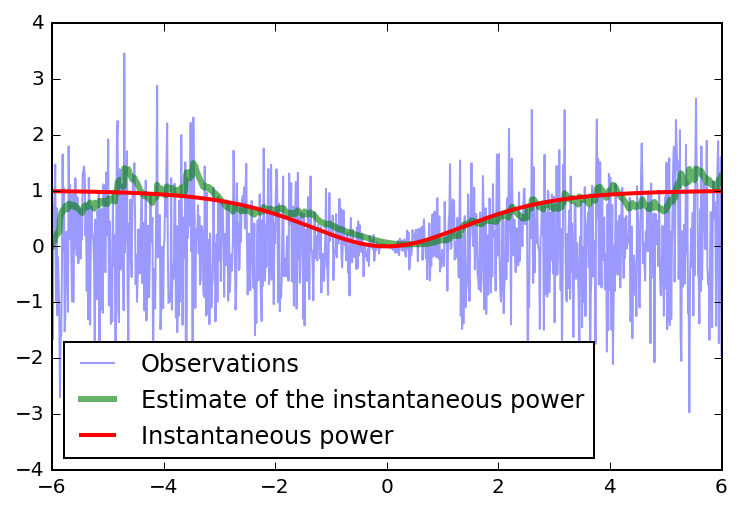

In [6]:
N=1000
from scipy.special import expit  # logistic function
x=np.random.normal(size=N)
t=np.linspace(-6,6,N)
z=x*(2*expit(t)-1)

def plt_vs_lambda(lamb):
    plt.plot(t,z,alpha=0.4,label='Observations')
    #We implement $s_\lambda(n)^2 = \lambda s_\lambda(n-1)^2 + x(n)^2.$
    slambda=np.zeros(N)
    for n in np.arange(1,N):
        slambda[n]=lamb*slambda[n-1]+z[n]**2
    plt.plot(t,slambda*(1-lamb),lw=3,alpha=0.6,label='Estimate of the instantaneous power')
    plt.plot(t,(2*expit(t)-1)**2,lw=2,label='Instantaneous power')
    plt.legend(loc='best')

lamb=widgets.FloatSlider(min=0,max=1,value=0.8, step=0.01)
_=interact(plt_vs_lambda, lamb=lamb)    

In [5]:
%matplotlib inline

Let us return to the normal equation (\ref{eq:wopt}):
$$
\wbopt=\Rb_{uu}^{-1} \Rb_{du}
$$
and to  its SDA version (\ref{eq:grad}):
\begin{align}
\wb(n+1) & = \wb(n) - \mu \E{ \ub(n) e(n) } \\
& = \wb(n) - \mu \left(\Rb_{uu} \wb(n) -  \Rb_{du} \right) \\
\end{align}
We will substitute the true values with estimated ones. 
An important remark is that the result of the normal equation is insensitive to a scale factor on the estimates. It is thus possible to estimate the correlation matrix and vector using a sliding average
$$
\begin{cases}
\hat\Rb_{uu}(n) = \sum_{l=-L}^L \ub(n-l)\ub(n-l)^H \\
\hat\Rb_{du}(n) = \sum_{l=-L}^L \d(n-l)\ub(n-l) 
\end{cases}
$$
or by an exponential mean
$$
\hat\Rb_{uu}(n) = \sum_{l=0}^n \lambda^{l-n} \ub(l)\ub(l)^H = \lambda \hat\Rb_{uu}(n-1) + \ub(n)\ub(n)^H
$$
which yields
$$
\begin{cases}
\hat\Rb_{uu}(n) = \sum_{l=0}^n \lambda^{l-n} \ub(l)\ub(l)^H = \lambda \hat\Rb_{uu}(n-1) + \ub(n)\ub(n)^H\\
\hat\Rb_{du}(n) = \lambda \hat\Rb_{du}(n-1) + d(n) \ub(n).\\
\end{cases}
$$

### The Least Mean Square (LMS) Algorithm 

The simplest estimator that can be defined is the limit case where we do not average at all... That is we take either $L=0$ or $\lambda=0$ in the previous formulas, to get the `instantaneous estimates`  
$$
\begin{cases}
\hat\Rb_{uu}(n) =  \ub(n)\ub(n)^H\\
\hat\Rb_{du}(n) = d(n) \ub(n).\\
\end{cases}
$$
This merely consists in suppressing the expectations in the theoretical formulas. So doing, we obtain formulas which directly depend on the data, with no need to know something on the theoretical statistics, and which also depend on time, thus confering adaptivity to the algorithm. Plugging these estimates in the SDA, we obtain
\begin{align}
\wb(n+1) & = \wb(n) - \mu  \ub(n) e(n)  \\
& = \wb(n) - \mu \ub(n) \left(\ub(n)^H \wb(n) -  d(n) \right) \\
\label{eq:lms}
\end{align}

Substituting $\ub(n)\ub(n)^H$ for $\E{\ub(n)\ub(n)^H}$, or ${ \ub(n) e(n) }$ for $\E{ \ub(n) e(n) }$ is really a  crude approximation. Nevertheless, the  averaging occurs by the iterating process so that this kind of method works. The LMS algorithm is  by far the most commonly used adaptive filtering algorithm, because it is extremely simple to implement, has a very low computational load, works relatively well and has tracking capabilities. 

In order to illustrate the behavior of the LMS algorithm, we continue the example of the identification of an unknown system. We first recreate the data:

### Illustation of the LMS in an identification problem

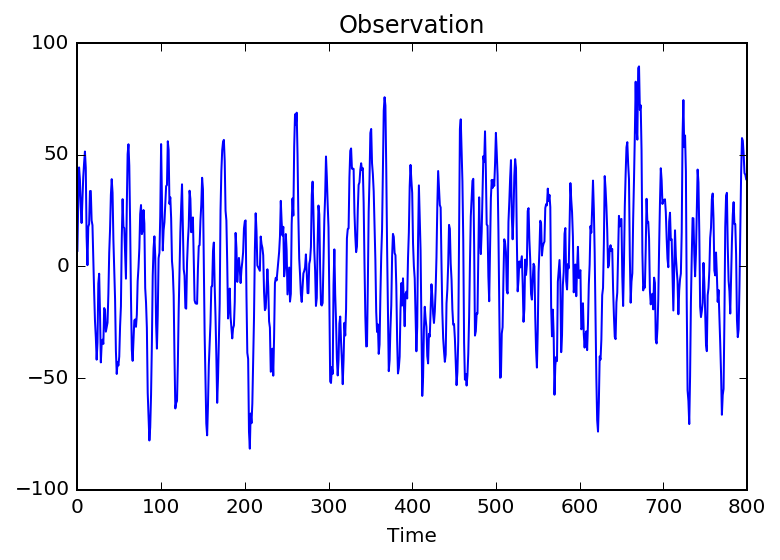

In [9]:
from scipy.signal import lfilter
# test
figplot=True
N=800
x=lfilter([1, 1], [1], np.random.randn(N))
htest=10*np.array([1, 0.7, 0.7, 0.7, 0.3, 0 ])
y0=lfilter(htest,[1],x)
y=y0+0.1*randn(N)
if figplot:
    plt.plot(y)
    plt.xlabel("Time")
    plt.title("Observation")
    figcaption("System output in an identification problem")

Now, since one should do it at least one time, try to implement a LMS algorithm. You will will define a function with the following syntax:

In [ ]:
def lms(d,u,w,mu):
    """ 
    Implements a single iteration of the stochastic gradient (LMS)\n
    :math:`w(n+1)=w(n)+\\mu u(n)\\left(d(n)-w(n)^T u(n)\\right)̀`
    
    Input:
    ======
        d : desired sequence at time n 
        u : input of length p
        w : wiener filter to update 
        mu : adaptation step
    
    Returns:
    =======
        w : upated filter
        err : d-dest
        dest : prediction = :math:`u(n)^T w` 
    """
    dest=0
    err=d-dest
#
# DO IT YOURSELF!
#
    return (w,err,dest)

You may test your function using the following validation:

In [ ]:
np.random.seed(327)
wout, errout, destout = lms(np.random.normal(1),np.random.normal(6),np.zeros(6),0.05)
wtest = np.array([ 0.76063565,  0.76063565,  0.76063565,  0.76063565,  0.76063565, 0.76063565])
#Test
if np.shape(wout)==np.shape(wtest):
    if np.sum(np.abs(wout-wtest))<1e-8:
        print("Test validated")
    else:
        print("There was an error in implementation")    
else:
    print("Error in dimensions") 

A possible implementation is given now

In [11]:
def lms(d,u,w,mu):
    """ 
    Implements a single iteration of the stochastic gradient (LMS)\n
    :math:`w(n+1)=w(n)+\\mu u(n)\\left(d(n)-w(n)^T u(n)\\right)̀`
    
    Input:
    ======
        d : desired sequence at time n 
        u : input of length p
        w : wiener filter to update 
        mu : adaptation step
    
    Returns:
    =======
        w : upated filter
        err : d-dest
        dest : prediction = :math:`u(n)^T w` 
    """
    dest=u.dot(w)
    err=d-dest
    w=w+mu*u*err
    return (w,err,dest)

#### Identification procedure

-  Begin by some direct commands (initializations and a `for` loop on the time variable) for identifying the filter; once this works you will implement th commands as a function `ident` 
- If necessary, the function `squeeze()` enable to remove single-dimensional entries from the shape of an n-D array  (*e.g.* transforms an array (3,1,1) into a vector of dimension 3)

In order to evaluate the algorithm behavior, you will plot the estimation error, the evolution of the coefficients of the identified filter during the iterations of the algorithm; and finally the quadratic error between the true filter and the identified one. This should be done for several orders $p$ (the exact order is unknown...) and for different values of the adaptation step $\mu$. 

- The quadratic error can be evaluated simply thanks to a  *comprehension list* according to 
         Errh=[sum(he-w[:,n])**2 for n in range(N+1)]

Study the code below, and implement the missing lines. 

In [ ]:
mu=0.1 # an initial value for mu
L=6  # size of identified filter (true size is p)
NN=200 #number of iterations
err=np.zeros(NN)
w=zeros((L,NN+1))
yest=np.zeros(NN)

# The key lines are here: you have to iterate over time and compute
# the output of the LMS at each iteration.You may save all outputs in the matrix 
# w initialized above -- column k contains the solution at time k. You must 
# also save the succession of errors, and the estimated output
#
# You have two lines to implement here.
# DO IT YOURSELF!
#
# After these lines, (w[:,t+1],err[t],yest[t]) are defined


# This is used to define the "true" impulse response  vector with the same size as w:
# a shorter (truncated) one if L<p, and a larger one (zero-padded) if L>p.
newhtest=np.zeros(L)
if np.size(htest)<L:
    newhtest=htest[:L]
else:
    newhtest[:np.size(htest)]=htest
    
# Results:
plt.figure(1)
tt=np.arange(NN)
plt.plot(tt,y0[:NN],label='Initial Noiseless Output')
plt.plot(tt,yest[:NN], label="Estimated Output")
plt.xlabel('Time')
figcaption("Comparison of true output and estimated one after identification", 
           label="fig:ident_lms_compareoutputs")

plt.figure(2)
errh=[sum((newhtest-w[:,t])**2) for t in range(NN)]
plt.plot(tt,errh,label='Quadratic error on h')
plt.legend()
plt.xlabel('Time')
figcaption("Quadratic error between true and estimated filter", 
           label="fig:ident_lms_eqonh")

The solution is given below:

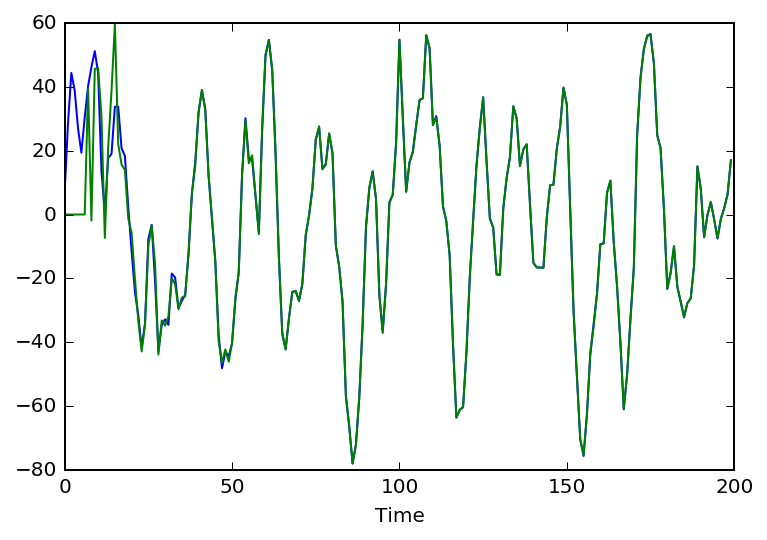

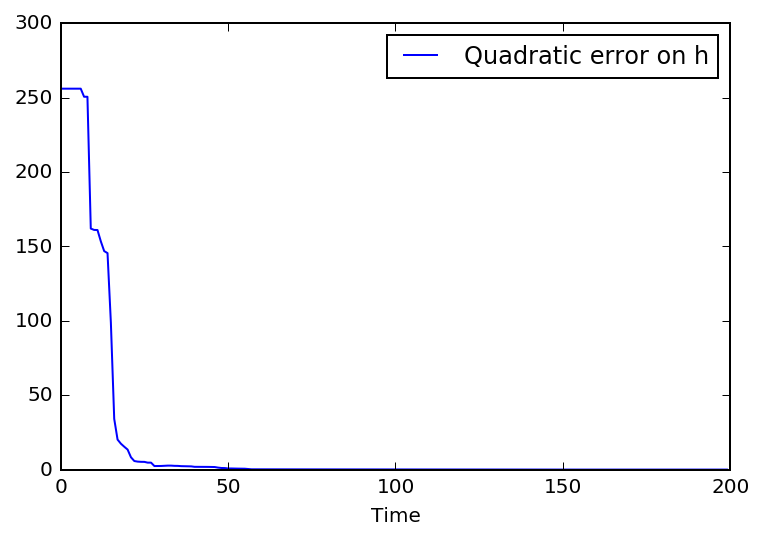

In [14]:

mu=0.1 # an initial value for mu
L=6  # size of identified filter (true size is p)
NN=200 #number of iterations
err=np.zeros(NN)
w=zeros((L,NN+1))
yest=np.zeros(NN)


# The key lines are here: you have to iterate over time and compute
# the output of the LMS at each iteration.You may save all outputs in the matrix 
# w initialized above -- column k contains the solution at time k. You must 
# also save the succession of errors, and the estimated output

for t in np.arange(L,NN):
    (w[:,t+1],err[t],yest[t])=lms(y[t],x[t:t-L:-1],w[:,t],mu)


# This is used to define the "true" impulse response  vector with the same size as w:
# a shorter (truncated) one if L<p, and a larger one (zero-padded) if L>p.
newhtest=np.zeros(L)
LL=np.min([np.size(htest),L])
newhtest[:LL]=htest[:LL]
      
# Results:
plt.figure(1)
tt=np.arange(NN)
plt.plot(tt,y0[:NN],label='Initial Noiseless Output')
plt.plot(tt,yest[:NN], label="Estimated Output")
plt.xlabel('Time')
figcaption("Comparison of true output and estimated one after identification", 
           label="fig:ident_lms_compareoutputs")

plt.figure(2)
errh=[sum((newhtest-w[:,t])**2) for t in range(NN)]
plt.plot(tt,errh,label='Quadratic error on h')
plt.legend()
plt.xlabel('Time')
figcaption("Quadratic error between true and estimated filter", 
           label="fig:ident_lms_eqonh")

We can now implement the identification as a function on its own, which simply maked some initializations and use a loop on the LMS. Implement this function according to the following syntax. 

In [ ]:
def ident(observation,input_data,mu,p=20,h_initial=zeros(20)):
    """ Identification of an impulse response from an observation
    `observation` of its output, and from its input `input_data` 
    `mu` is the adaptation step\n
    Inputs:
    =======
    observation: array
        output of the filter to identify
    input_data: array
        input of the filter to identify
    mu: real
        adaptation step
    p: int (default =20)
        order of the filter
    h_initial: array (default h_initial=zeros(20))
        initial guess for the filter
    normalized: boolean (default False)    
        compute the normalized LMS instead of the standard one
    
    Outputs:
    ========
    w: array
        identified impulse response
    err: array
        estimation error
    yest: array
        estimated output
    """
    N=np.size(input_data)
    err=np.zeros(N)
    w=np.zeros((p,N+1))
    yest=np.zeros(N)

   #
   # DO IT YOURSELF!
   #
        
    return (w,err,yest)

In [ ]:
def ident(observation,input_data,mu,p=20,h_initial=zeros(20),normalized=False):
    """ Identification of an impulse response from an observation
    `observation` of its output, and from its input `input_data` \n
    `mu` is the adaptation step\n
    Inputs:
    =======
    observation: array
        output of the filter to identify
    input_data: array
        input of the filter to identify
    mu: real
        adaptation step
    p: int (default =20)
        order of the filter
    h_initial: array (default h_initial=zeros(20))
        initial guess for the filter
    Outputs:
    ========
    w: array
        identified impulse response
    err: array
        estimation error
    yest: array
        estimated output
    """
    N=np.size(input_data)
    input_data=squeeze(input_data) #reshape(input_data,(N))
    observation=squeeze(observation)
    err=np.zeros(N)
    w=np.zeros((p,N+1))
    yest=np.zeros(N)

    w[:,p]=h_initial
    for t in range(p,N):   
        if normalized:
            mun=mu/(dot(input_data[t:t-p:-1],input_data[t:t-p:-1])+1e-10)   
        else:
            mun=mu
        (w[:,t+1],err[t],yest[t])=lms(observation[t],input_data[t:t-p:-1],w[:,t],mun)
        
    return (w,err,yest)

Your implementation can simply be tested with

In [ ]:
L=8
(w,err,yest)=ident(y,x,mu=0.05,p=L,h_initial=zeros(L))

newhtest=np.zeros(L)
LL=np.min([np.size(htest),L])
newhtest[:LL]=htest[:LL]

NN=np.min([np.size(yest),200])
errh=[sum((newhtest-w[:,t])**2) for t in range(NN)]
plt.plot(tt,errh,label='Quadratic error on h')
plt.legend()
_=plt.xlabel('Time')
print("Identified filter: ",w[:,-1])

In [16]:
def ident(observation,input_data,mu,p=20,h_initial=zeros(20),normalized=False):
    """ Identification of an impulse response from an observation
    `observation` of its output, and from its input `input_data` 
    `mu` is the adaptation step\n
    Inputs:
    =======
    observation: array
        output of the filter to identify
    input_data: array
        input of the filter to identify
    mu: real
        adaptation step
    p: int (default =20)
        order of the filter
    h_initial: array (default h_initial=zeros(20))
        initial guess for the filter
    normalized: boolean (default False)    
        compute the normalized LMS instead of the standard one
    
    Outputs:
    ========
    w: array
        identified impulse response
    err: array
        estimation error
    yest: array
        estimated output
    """
    N=np.size(input_data)
    err=np.zeros(N)
    w=np.zeros((p,N+1))
    yest=np.zeros(N)

    w[:,p]=h_initial
    for t in np.arange(p,N):   
        if normalized:
            assert mu<2, "In the normalized case, mu must be less than 2"
            mun=mu/(np.dot(input_data[t:t-p:-1],input_data[t:t-p:-1])+1e-10)   
        else:
            mun=mu
        (w[:,t+1],err[t],yest[t])=lms(observation[t],input_data[t:t-p:-1],w[:,t],mun)
        
    return (w,err,yest)

#### Stability of results

It is very instructive to look at the reproductibility of results when the data change. Let $\mu$ fixed and generate new data. Then apply  the identification procedure and plot the learning curve. 

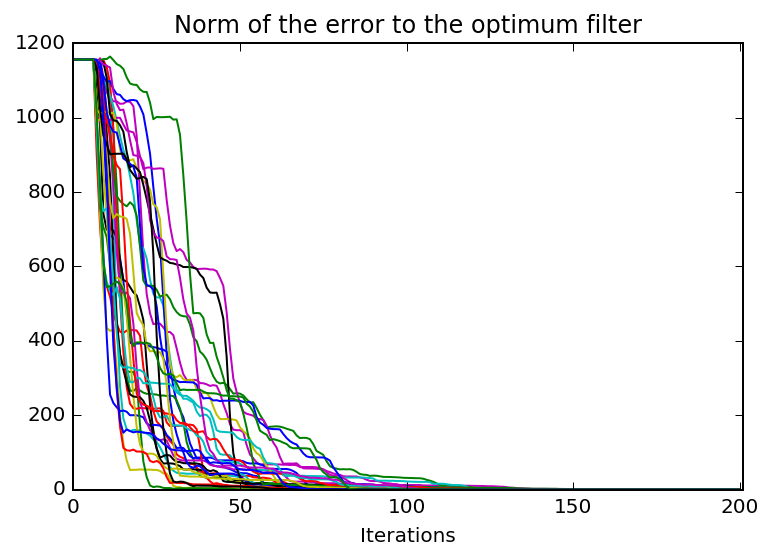

In [17]:
p=6 #<-- actual length of the filter
for ndata in range(30):
    ## Generate new datas
    N=200
    x=lfilter([1, 1], [1], np.random.randn(N))
    htest=10*np.array([1, 0.7, 0.7, 0.7, 0.3, 0 ])
    y0=lfilter(htest,[1],x)
    y=y0+0.1*randn(N)
    iterations=np.arange(NN+1)
    # --------------------

    for mu in [0.01]:
        (w,erreur,yest)=ident(y,x,mu,p=p,h_initial=zeros(p))
        Errh=[sum(htest-w[:,n])**2 for n in range(NN+1)]
        plt.plot(iterations,Errh, label="$\mu={}$".format(mu))
        plt.xlim([0, NN+1])


plt.title("Norm of the error to the optimum filter")
_=plt.xlabel("Iterations")

The data are random; the algorithm is stochastic and so is the learning curve! Fortunately, we still check that the algorithms converge... since the error goes to zero. So, it works.

#### Study with respect to $\mu$

It is really a simple task to study the behavior with respect to the choice of the stepsize $\mu$. We just have to make a loop over possible values of $\mu$, call the identification procedure and display the results.

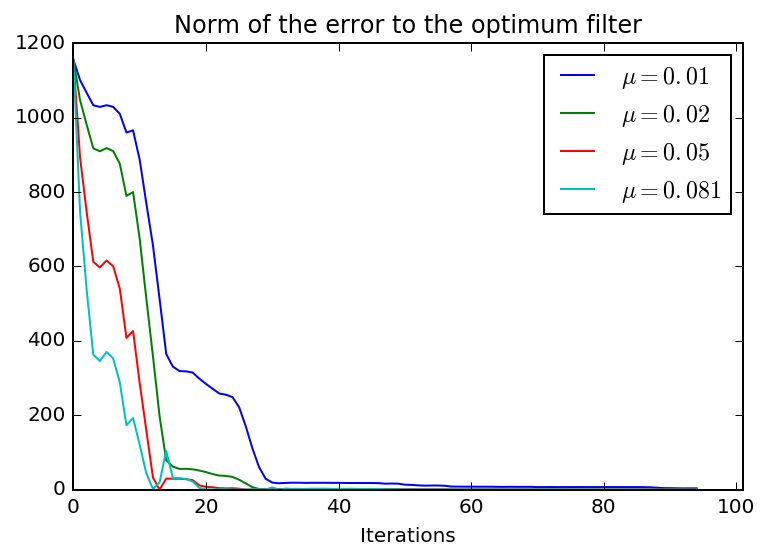

In [18]:
 # Study with respect to $\mu$    
p=6
NN=100
iter=np.arange(NN+1)-p

## Generate new datas
N=200
x=lfilter([1, 1], [1], np.random.randn(N))
htest=10*np.array([1, 0.7, 0.7, 0.7, 0.3, 0 ])
y0=lfilter(htest,[1],x)
y=y0+0.1*randn(N)
# --------------------

for mu in [0.01, 0.02, 0.05, 0.081]:
    (w,erreur,yest)=ident(y,x,mu,p=p,h_initial=zeros(p))
    Errh=[sum(htest-w[:,n])**2 for n in range(NN+1)]
    plt.plot(iter,Errh, label="$\mu={}$".format(mu))
    plt.xlim([0, NN+1])
    
plt.legend()
plt.title("Norm of the error to the optimum filter")
_=plt.xlabel("Iterations")

#### Tracking capabilities

With a constant step-size, the LMS never converge, since while an error exist, the filter is always updated. A consequence of this fact is that the LMS keeps tracking capabilities, which are especially useful in a non-stationary context. In the identification concept, it is possible that the filter to be identified varies during time. In such case, the algorithm must be able to track these modifications. Such an example is simulated below, where the impulse response is modulated by a $\cos()$, according to
$$
h(t,\tau) = \left(1+ \cos(2\pi f_0 t)\right) h_\mathrm{test}(\tau).
$$


In [ ]:
### Slow non-stationarity

N=1000
u=np.random.randn(N)
y=np.zeros(N)
htest=10*np.array([1, 0.7, 0.7, 0.7, 0.3, 0 ])
L=size(htest)
for t in np.arange(L,N):
    y[t]=dot((1+cos(2*pi*t/N))*htest,u[t:t-L:-1])
y+=0.01*np.random.randn(N)
plt.figure()
plt.plot(y)
_=plt.title("Observed Signal")

Then, we can test the identification procedure for this non stationary signal. We check that the error indeed goes to zero, and that the identified filter seem effectively modulated with a cosine. 

In [ ]:
p=7
(w,err,yest)=ident(y,u,mu=0.1,p=p,h_initial=zeros(p))
#(w,err,yest)=ident(y,u,mu=1,p=p,h_initial=zeros(p),normalized=True)
plt.figure(1)
clf()
plt.plot(err)
plt.title('Identification error')
figcaption("Identification error in the nonstationary case", label="fig:error_ns_case")
plt.figure(2)
plt.clf()
t=np.arange(0,N+1)
true_ns_h=np.outer((1+cos(2*pi*t/N)),htest)
plt.plot(t,w.T,lw=1)
plt.plot(t,true_ns_h,lw=2,label="True values", alpha=0.4)
plt.title("Evolution of filter's coefficients")
figcaption("Evolution of filter's coefficients", label="fig:coeff_ns_case")

### Convergence properties of the LMS

As we realize with these numerical experiments, since the LMS directly depends of the data, the algorithm itself is stochastic; the learning curves have a random character but the mean trajectories still converge to the correct solution. The correct characterization of stochastic algorithms is difficult -- actually, the first correct analysis is due to Eweda and Macchi (1983). The traditional analysis relies on a false hypothesis, the *independence assumption*, which still gives a good idea of what happens.   

The idea is simply that the average algorithm 
\begin{align}
\E{\wb(n+1)} & = \E{\wb(n) - \mu {\ub(n)\left(\ub(n)^T\wb(n)-d(n) \right) }} \\
& =   \E{\wb(n)} - \mu \E{\ub(n)\left(\ub(n)^T\wb(n)-d(n) \right) } \\
& \approx   \E{\wb(n)} - \mu \left( \E{\ub(n)\ub(n)^T}\E{\wb(n)}-\E{\ub(n)d(n)} \right)
\end{align}
is exactly the true gradient algorithm. Thus, we would have exactly the same conditions for convergence as  for the gradient algorithm. However, this is only an approximation. Indeed, in the third line the equality $\E{\ub(n)\ub(n)^T\wb(n)}=\E{\ub(n)\ub(n)^T}\E{\wb(n)}$ is incorrect since obviously $\wb(n)$ depends on $\ub(n)$ through the components at times $n-1, n-2,$ etc. 

Furthermore, it must be stressed that the learning curves are now **random**. Thus, we can understand that the convergence conditions are more strict than for the gradient algorithm. A practical rule for the choice of $\mu$ is 
$$
\mu = \frac{2}{\alpha \mathrm{Tr}\left[\Rb_{uu}\right]} = \frac{2}{\alpha pR_{uu}(0)},
$$
where $\alpha$ is a scalar between 2 and 3, $R_{uu}(0)=\E{|u(n)|^2}$ and $p$ is the dimension of the correlation matrix. 

... to be continued...

### The normalized LMS

A simple variant of the LMS relies on the idea of introducing an non constant step-size $\mu_n$ and to determine an optimum value for the step-size at each iteration. A simple way to show the result is as follows. 
- The standard error, before updating the LMS from $\wb(n)$ into $\wb(n+1)$,  is 
$$e(n|n)=\wb(n)^T\ub(n) - d(n)$$
- After having updated the filter, we can recompute the error, as
$$e(n|n+1)=\wb(n+1)^T\ub(n) - d(n).$$
This error is called *a posteriori* error, since it is calculated with the updated filter. This is also indicated by the notation $.|n+1$ which means "computed using the filter at time $n+1$.  The standard error is thus qualified of *a priori* error. 

Since $\wb(n+1)=\wb(n)-\mu\ub(n)e(n|n)$, we immediately get that
\begin{align}
e(n|n+1)& =\wb(n+1)^T\ub(n) - d(n) \\
& = \left(\wb(n)-\mu_n\ub(n)e(n|n)\right)^T\ub(n) - d(n) \\
& = e(n|n)-\mu_n\ub(n)^T\ub(n)e(n|n) \\
& = \left(1-\mu_n\ub(n)^T\ub(n)\right) e(n|n) 
\end{align}
Evidently, updating must decrease the error. Thus, we must have 
$$
|e(n|n+1)| \leq |e(n|n)|
$$
that is
$$
\left|\left(1-\mu_n\ub(n)^T\ub(n)\right)\right| \leq 1.
$$
This yields the condition
$$
\eqboxc{
0\leq\mu_n \leq \frac{2}{\ub(n)^T\ub(n)}
}.
\label{eq:murangenlms}
$$
The optimum value of the step-size corresponds to the minimum of |e(n|n+1)|, which is simply given by 
$$
\eqboxc{
\mu_n = \frac{1}{\ub(n)^T\ub(n)}
}.
$$
However, the **normalized LMS algorithm** is often given with an auxiliary factor, say $\tilde\mu$, which adds a tuning parameter the algorithm
$$
\eqboxd{
\wb(n+1)=\wb(n)-\frac{\tilde\mu}{\ub(n)^T\ub(n)} \ub(n)\left(\wb(n)^T\ub(n) -d(n)\right) 
}
$$
The condition (\ref{eq:murangenlms}) directly gives
$$
\eqboxd{0\leq\tilde\mu\leq2},
\label{eq:murangenlms_2}
$$
which is a very simple rule.

Implementation of the normalized LMS is a simple modification of the standard LMS. Note that it is useful to introduce a small positive constant in the definition of the step-size
$$
\mu_n = \frac{1}{\ub(n)^T\ub(n)+\epsilon}
$$
in order to avoid division by zero errors.

In [ ]:
def normalized_lms(d,u,w,mu):
    """ 
    Implements a single iteration of the stochastic gradient (LMS)\n
    :math:`w(n+1)=w(n)+\\mu u(n)\\left(d(n)-w(n)^T u(n)\\right)̀`
    
    Input:
    ======
        d : desired sequence at time n 
        u : input of length p
        w : wiener filter to update 
        mu : adaptation step for the NLMS; mu <2
    
    Returns:
    =======
        w : upated filter
        err : d-dest
        dest : prediction = :math:`u(n)^T w` 
    """
    assert mu<2, "In the normalized case, mu must be less than 2"
    u=squeeze(u) #Remove single-dimensional entries from the shape of an array.
    w=squeeze(w)
    dest=u.dot(w)
    err=d-dest
    mun=mu/(dot(u,u)+1e-10)  
    w=w+mun*u*err
    return (w,err,dest)

### Other variants of the LMS

The stochastic gradient algorithm is obtained from the theoretical gradient algorithm by approximating the exact statistical quantities by their instantaneous values. This approach can be extended to arbitrary cost functions. Indeed, if we consider a cost function $J(\wb)=\E{f(e(n))}$, with $f$ a positive even function, then the steepest descent algorithm leads to
\begin{align}
\wb(n+1) & =\wb(n) - \mu \deriv{\E{f(e(n))}}{\wb(n)} \\
& = \wb(n) - \mu \E{\ub(n) \deriv{f(e(n))}{\wb(n)}},\\
\end{align}
where we used the chain rule for derivation.

The corresponding stochastic gradient algorithm is then immediately given by
$$
\wb(n+1) = \wb(n) - \mu {\ub(n) \deriv{f(e(n))}{e(n)}}.
$$
Let us look at some examples:
\begin{itemize}
\item if $f(e)=|e|$, then $f'(e)=\mathrm{sign}(e)$ and we obtain the so-called **sign-error** algorithm:
$$
\wb(n+1) = \wb(n) - \mu {\ub(n)\mathrm{sign}(e(n)) }.
$$
This is an early algorithm with very low complexity, which can be implemented without any multiplications (if $\mu$ is a power of 2, then the step-size multiplication can be 
implemented as a bit shift).
\item for $f(e)=|e|^k$, then  $f'(e)=k|e|^{k-1}\mathrm{sign}(e)$, and the stochastic gradient algorithm has the form
$$
\wb(n+1) = \wb(n) - \mu {\ub(n)|e(n)|^{k-1}\mathrm{sign}(e(n)) }.
$$
\end{itemize}

See [Mathews, ece6550 -chapter4](http://www.ece.utah.edu/~mathews/ece6550/chapter4.pdf), page 22, for an example of a piecewise linear cost function leading to a quantization of the error.  

### Recursive Least Squares

Instead of taking an instantaneous estimate of the correlation matrix and vector, it is still possible to go on with the exponential mean estimates
$$
\begin{cases}
\hat\Rb_{uu}(n+1) = \sum_{l=0}^{n+1} \lambda^{l-n-1} \ub(l)\ub(l)^H = \lambda \hat\Rb_{uu}(n) + \ub(n+1)\ub(n+1)^H\\
\hat\Rb_{du}(n+1) = \lambda \hat\Rb_{du}(n) + d(n+1) \ub(n+1).\\
\end{cases}
$$
It remains to compute the solution
\begin{equation}
\hat\wb(n+1) =  \left[\hat\Rb_{uu}(n+1)\right]^{-1} \hat\Rb_{du}(n+1).
\end{equation}
The main problem is the inversion, for each $n$, of the correlation matrix. Fortunately, it is possible to obtain a recursive  solution which do not need a matrix inversion at all...
The key here is to invoke the [matrix inversion lemma](http://en.wikipedia.org/wiki/Woodbury_matrix_identity)
\begin{equation}
[\Ab + \Bb\Db]^{-1} = \Ab^{-1} - \Ab^{-1}\Bb[\Ib + 
\Db\Ab^{-1}\Bb]^{-1}\Db\Ab^{-1}.
\end{equation}
Applying this with $\Ab=\lambda \hat\Rb_{uu}(n-1)$, $\Bb=\ub(n)$ and $\Cb=\ub(n)^H$, and denoting 
$$
\Kb_{n+1} = \left[\hat\Rb_{uu}(n+1)\right]^{-1} 
$$
we readily obtain
\begin{equation}
\Kb(n+1) = \frac{1}{\lambda}\Kb(n) - 
\frac{1}{\lambda^2} \frac{\Kb(n)\ub(n+1)\ub(n+1)^H \Kb(n)}{1+\frac{1}{\lambda}\ub(k+1)^H\Kb(n)\ub(k+1)},
\end{equation}
and after several lines of calculations, we arrive at the updating formula
\begin{equation}
\hat\wb(n+1) = \hat\wb(n) + \Kb(n+1)\ub(n+1)[d(n+1)-\wb(n)^H\ub(n+1)].
\end{equation}
Note that there are some notational differences between the LMS and the RLS. For the LMS, the filter $\wb(n+1)$ is calculated based on the data available at time $n$. For the RLS,  $\wb(n+1)$ is computed using data available at time ($n+1$). This is just a notational difference -- we could easily rename $\wb(n+1)$ into say $\vb(n)$ and obtain similar indexes. However these notations are traditional, so we follow the classical developments and equations. What is important however is to note that both filters are calculated using the *a priori* error, that is the error using the data at time $n$ and the filter computed using the data at time $n-1$. 

##### Initialization - 

The initialization of the algorithm requires the specification of an initial $\wb(0)$ which is usually taken as a null vector. It also requires specifying $\Kb(0)$. Since $\Kb(0)$ is the inverse of the correlation matrix before the beginning of the iterations, we usually choose $\Rb_{uu}(0)=\delta\Ib$, with $\delta$ very small. So the inverse is $\Kb(0)=\delta^{-1}\Ib$, a large value which disappears during the iterations of the algorithm.

An implementation of the RLS algorith is proposed below, using the standard `numpy array` type as well as the `matrix` type. Casting from one type to the other is done by `np.matrix` or `np.array` keywords (which make a copy), or using `np.asmatrix` or `np.asarray` keywords. 

In [ ]:
# Implementation using the array type
def algo_rls(u,d,M,plambda):
    N=size(u)
# initialization
    e=zeros(N)
    wrls=zeros((M,N+1))
    Krls=100*eye(M)
    u_v=zeros(M)
    for n in range(N):
        u_v[0]=u[n]
        u_v[1:M]=u_v[0:M-1]#concatenate((u[n], u_v[1:M]), axis=0)
        e[n]=conj(d[n])-dot(conj(u_v),wrls[:,n])
        # print("n={}, Erreur de {}".format(n,e[n]))
        Kn=Krls/plambda
        Krls=Kn-dot(Kn,dot(outer(u_v,conj(u_v)),Kn))/(1+dot(conj(u_v),dot(Kn,u_v)))
        wrls[:,n+1]=wrls[:,n]+dot(Krls,u_v)*conj(e[n])
    return (wrls,e)

## RLS, matrix version

def col(v):
     """ transforms an array into a column vector \n
     This is the equivalent of  x=x(:) under Matlab"""
     v=asmatrix(v.flatten())
     return reshape(v,(size(v),1))
    
def algo_rls_m(u,d,M,plambda):
    """
    Implementation with the matrix type instead of the array type
    """
    N=size(u)
	# initialization
    e=zeros(N)
    wrls=matrix(zeros((M,N+1)))
    Krls=100*matrix(eye(M))
    u=col(u)
    u_v=matrix(col(zeros(M)))
        
    for n in range(N):
        u_v[0]=u[n]
        u_v[1:M]=u_v[0:M-1]
		#u_v=concatenate(u[n], u_v[:M], axis=0)
        e[n]=conj(d[n])-u_v.H*wrls[:,n]
        Kn=Krls/plambda
        Krls=Kn-Kn*(u_v*u_v.H*Kn)/(1+u_v.H*Kn*u_v)
        wrls[:,n+1]=wrls[:,n]+Krls*u_v*conj(e[n])
      
    return (wrls,e)

At this point, it would be useful to do again the previous experimentations (identification with non stationary data) with the RLS algorithm. Then to compare and conclude.


In [ ]:
def ident_rls(observation,input_data,factor_lambda=0.95,p=20):
    """ Identification of an impulse response from an observation
    `observation` of its output, and from its input `input_data` \n
    `mu` is the adaptation step\n
    Inputs:
    =======
    observation: array
        output of the filter to identify
    input_data: array
        input of the filter to identify
    factor_lambda: real (defaut value=0.95)
        forguetting factor in the RLS algorithm
    p: int (default =20)
        order of the filter    
    Outputs:
    ========
    w: array
        identified impulse response
    err: array
        estimation error
    yest: array
        estimated output
    """
    N=np.size(input_data)
    input_data=squeeze(input_data) #reshape(input_data,(N))
    observation=squeeze(observation)
    (wrls,e)= algo_rls(input_data,observation,p,factor_lambda)
#   (w[:,t+1],erreur[t],yest[t])=lms(input_data[t:t-p:-1],w[:,t],mun)      
    return (wrls,e)

In [ ]:
### Slow non-stationarity

N=1000
u=np.random.randn(N)
y=np.zeros(N)
htest=10*np.array([1, 0.7, 0.7, 0.7, 0.3, 0 ])
L=size(htest)
for t in np.arange(L,N):
    y[t]=dot((1+cos(2*pi*t/N))*htest,u[t:t-L:-1])
y+=0.01*np.random.randn(N)
plt.figure()
plt.plot(y)
_=plt.title("Observed Signal")

In [ ]:
p=7
lamb=0.97
(w,err)=ident_rls(y,u,factor_lambda=lamb,p=10)
plt.figure(1)
clf()
plt.plot(err)
plt.title('Identification error')
figcaption("Identification error in the nonstationary case", label="fig:error_ns_case")
plt.figure(2)
plt.clf()
t=np.arange(0,N+1)
true_ns_h=np.outer((1+cos(2*pi*t/N)),htest)
plt.plot(t,w.T,lw=1)
plt.plot(t,true_ns_h,lw=2,label="True values", alpha=0.4)
plt.title("Evolution of filter's coefficients")
figcaption("Evolution of filter's coefficients", label="fig:coeff_ns_case")

References:

  - http://www.ece.utah.edu/~mathews/ece6550/chapter10.pdf
  - http://www.cs.tut.fi/~tabus/course/ASP/LectureNew10.pdf
  - [Recursive Least Squares at wikipedia](http://en.wikipedia.org/wiki/Recursive_least_squares_filter)
  - <a href="http://www.intechopen.com/books/adaptive-filtering-applications" title="Adaptive Filtering Applications">Adaptive Filtering Applications</a> (open access book at intechopen).

----
<div align=right> [Index](toc.ipynb) - [Back](Grad_algo.ipynb) - [Next](noisecancellationlab.ipynb)</div>